# How to train your DragoNN tutorial 4: 
## Interpreting predictive sequence features in  TF binding events within the GM12878 cell line. 

This tutorial is a supplement to the DragoNN manuscript and follows figure 8 in the manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data</a></li>
    <li><a href=#2>Generating positive and negative bins for genome-wide training </a></li>
    <li><a href=#3>Challenges of in vivo data : batch generators and class upsampling </a></li>
    <li><a href=#3.5>Optional: Download pre-generated models and test-set predictions </a></li>
    <li><a href=#4>Case 1: Negatives consist of shuffled references, single-tasked models</a></li>  
    <li><a href=#5>Case 2: Whole-genome negatives, single-tasked models </a></li>
    <li><a href=#6>Case 3: Whole-genome negatives, multi-tasked models </a></li>
    <li><a href=#7>Case 4: What happens if we don't upsample positive examples in our batches? </a></li>
    <li><a href=#8>Calibrate classification model predictions with Platt scaling</a></li>
    <li><a href=#9>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT </a></li>
    <li><a href=#10>Conclusions</a></li>    
</ol>
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.


In [2]:
# If you don't have bedtools installed in your environment (i.e. Google Colab), uncomment and run the command below 
#!apt-get install bedtools
#!pip install pybedtools

In [3]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install dragonn>=0.2.6

In [5]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [6]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Input data <a name='1'>
<a href=#outline>Home</a>

Tutorials 1 - 3 have used simulated data generated with the simdna package. In this tutorial, we will examine how well CNN's are able to predict transcription factor binding for four TF's in vivo. 

We will learn to predict transcription factor binding for four transcription factors in the GM12878 cell line (one of the Tier 1 cell lines for the ENCODE project). First, we download the narrowPeak bed files for each of these transcription factors. You can skip the following code block if you already have the data downloaded. 

In [ ]:
## CTCF, optimal IDR thresholded peaks, Stam Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000DRZ/
!wget -O CTCF.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/ctcf_ENCSR000DRZ/cromwell-executions/chip/e94d720e-08dd-42fa-bc77-2391e2b8c275/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz 

## SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget -O SPI1.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz
    
## ZNF143, optimal IDR thresholded peaks, Snyder lab, hg19
#https://www.encodeproject.org/experiments/ENCSR936XTK/
!wget -O ZNF143.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/znf143_ENCSR936XTK/cromwell-executions/chip/8e1d0af8-3ca6-44e2-aff0-af83b2c0c061/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz

    
## SIX5, optimal IDR thresholded peaks, Myers Lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BJE/
!wget -O SIX5.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/six5_ENCSR00BJE/cromwell-executions/chip/bd36ae6c-a9e3-4d71-a938-c45ab86854fc/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz

## Download "ambiguous" peak sets -- these peaks are in the optimal overlap set across replicates, but are not
## found to be reproducible at a high confidence (p<0.05) by IDR 
! wget -O CTCF.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/CTCF.ambiguous.gz
! wget -O SPI1.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.ambiguous.gz
! wget -O ZNF143.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/ZNF143.ambiguous.gz
! wget -O SIX5.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/SIX5.ambiguous.gz
    
## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.fai 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.gzi 


## Generating positive and negative bins for genome-wide training <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [7]:
from seqdataloader import * 

In [8]:
## seqdataloader accepts an input file, which we call tasks.tsv, with task names in column 1, the corresponding
## peak files in column 2, skip column 3 (which will be used for regression in Tutorial 5), and ambiguous peaks in 
## column4 
with open("tasks.tsv",'w') as f: 
    f.write("CTCF\tCTCF.narrowPeak.gz\t\tCTCF.ambiguous.gz\n")
    f.write("SPI1\tSPI1.narrowPeak.gz\t\tSPI1.ambiguous.gz\n")
    f.write("SIX5\tSIX5.narrowPeak.gz\t\tSIX5.ambiguous.gz\n")
    f.write("ZNF143\tZNF143.narrowPeak.gz\t\tZNF143.ambiguous.gz\n")
f.close() 
! cat tasks.tsv

CTCF	CTCF.narrowPeak.gz		CTCF.ambiguous.gz
SPI1	SPI1.narrowPeak.gz		SPI1.ambiguous.gz
SIX5	SIX5.narrowPeak.gz		SIX5.ambiguous.gz
ZNF143	ZNF143.narrowPeak.gz		ZNF143.ambiguous.gz


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* Each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. 

* The bin is labeled ambiguous (label = -1) and excluded from training if there is some overlap with the narrowPeak, but the peak summit does not lie in that overlap. 

* The bin is labeled negative if there is no overlap with the narrowPeak. 

In [ ]:
#we will include all chromosomes with the exception of 1,2, and 19 in our training set 

#1) Generate genome-wide negatives in addition to positives 
train_set_params={
    'task_list_sep':'\t',
    'task_list':"tasks.tsv",
    'outf':"TF.train.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'    
    }
genomewide_labels(train_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 

positives_train_set_params={
    'task_list_sep':'\t',
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.train.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_train_set_params)

In [ ]:
#We will include chromsome 1 in our validation set 

#1) Generate genome-wide negatives in addition to positives 
valid_set_params={
    'task_list_sep':'\t',
    'task_list':"tasks.tsv",
    'outf':"TF.valid.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)


#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_valid_set_params={
    'task_list_sep':'\t',
    'store_positives_only':True,
    'task_list':"tasks.tsv",
    'outf':"positives.TF.valid.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_valid_set_params)


In [ ]:
#We will include chromosomes 2 and 19 in our testing set 
test_set_params={
    'task_list_sep':"\t",
    'task_list':"tasks.tsv",
    'outf':"TF.test.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)

#2) Extract positive bins for each task for DeepBind training paradigm -- shuffled reference negatives to be 
#generated on the fly 
positives_test_set_params={
    'store_positives_only':True,
    'task_list_sep':"\t",
    'task_list':"tasks.tsv",
    'outf':"positives.TF.test.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':20,
    'subthreads':2,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(positives_test_set_params)


Let's examine the files that were generated: 

In [9]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
pd.read_hdf("TF.train.hdf5",start=0,stop=10)

CTCF  SPI1  SIX5  ZNF143
CHR  START END                           
chr3 0     1000   0.0   0.0   0.0     0.0
     50    1050   0.0   0.0   0.0     0.0
     100   1100   0.0   0.0   0.0     0.0
     150   1150   0.0   0.0   0.0     0.0
     200   1200   0.0   0.0   0.0     0.0
     250   1250   0.0   0.0   0.0     0.0
     300   1300   0.0   0.0   0.0     0.0
     350   1350   0.0   0.0   0.0     0.0
     400   1400   0.0   0.0   0.0     0.0
     450   1450   0.0   0.0   0.0     0.0

In [10]:
# When provided with the --store-positives_only flag, the code generates all bins for each task that are labeled positive.
pd.read_hdf("SPI1.positives.TF.train.hdf5",start=0,stop=10)

SPI1
CHR  START  END         
chr3 129600 130600   1.0
     129650 130650   1.0
     129700 130700   1.0
     129750 130750   1.0
     260300 261300   1.0
     260350 261350   1.0
     260400 261400   1.0
     260450 261450   1.0
     319100 320100   1.0
     319150 320150   1.0

In [11]:
#We load our test set labels into memory here, as we will use them to measure performance in cases 1 - 4 below.
#Note that we only load the labels into memory, not the actual test dataset. 

#It is not necessary to load the training/validation dataset or labels, see below. 
test_set=pd.read_hdf("TF.test.hdf5")
test_set

CTCF  SPI1  SIX5  ZNF143
CHR   START    END                               
chr2  0        1000       0.0   0.0   0.0     0.0
      50       1050       0.0   0.0   0.0     0.0
      100      1100       0.0   0.0   0.0     0.0
      150      1150       0.0   0.0   0.0     0.0
      200      1200       0.0   0.0   0.0     0.0
      250      1250       0.0   0.0   0.0     0.0
      300      1300       0.0   0.0   0.0     0.0
      350      1350       0.0   0.0   0.0     0.0
      400      1400       0.0   0.0   0.0     0.0
      450      1450       0.0   0.0   0.0     0.0
      500      1500       0.0   0.0   0.0     0.0
      550      1550       0.0   0.0   0.0     0.0
      600      1600       0.0   0.0   0.0     0.0
      650      1650       0.0   0.0   0.0     0.0
      700      1700       0.0   0.0   0.0     0.0
      750      1750       0.0   0.0   0.0     0.0
      800      1800       0.0   0.0   0.0     0.0
      850      1850       0.0   0.0   0.0     0.0
      900      1900       0.0   0.0   0.0     0.0
      950      1950       0.0   0.0   0.0     0.0
      1000     2000       0.0   0.0   0.0     0.0
      1050     2050       0.0   0.0   0.0     0.0
      1100     2100       0.0   0.0   0.0     0.0
      1150     2150       0.0   0.0   0.0     0.0
      1200     2200       0.0   0.0   0.0     0.0
      1250     2250       0.0   0.0   0.0     0.0
      1300     2300       0.0   0.0   0.0     0.0
      1350     2350       0.0   0.0   0.0     0.0
      1400     2400       0.0   0.0   0.0     0.0
      1450     2450       0.0   0.0   0.0     0.0
...                       ...   ...   ...     ...
chr19 59126500 59127500   0.0   0.0   0.0     0.0
      59126550 59127550   0.0   0.0   0.0     0.0
      59126600 59127600   0.0   0.0   0.0     0.0
      59126650 59127650   0.0   0.0   0.0     0.0
      59126700 59127700   0.0   0.0   0.0     0.0
      59126750 59127750   0.0   0.0   0.0     0.0
      59126800 59127800   0.0   0.0   0.0     0.0
      59126850 59127850   0.0   0.0   0.0     0.0
      59126900 59127900   0.0   0.0   0.0     0.0
      59126950 59127950   0.0   0.0   0.0     0.0
      59127000 59128000   0.0   0.0   0.0     0.0
      59127050 59128050   0.0   0.0   0.0     0.0
      59127100 59128100   0.0   0.0   0.0     0.0
      59127150 59128150   0.0   0.0   0.0     0.0
      59127200 59128200   0.0   0.0   0.0     0.0
      59127250 59128250   0.0   0.0   0.0     0.0
      59127300 59128300   0.0   0.0   0.0     0.0
      59127350 59128350   0.0   0.0   0.0     0.0
      59127400 59128400   0.0   0.0   0.0     0.0
      59127450 59128450   0.0   0.0   0.0     0.0
      59127500 59128500   0.0   0.0   0.0     0.0
      59127550 59128550   0.0   0.0   0.0     0.0
      59127600 59128600   0.0   0.0   0.0     0.0
      59127650 59128650   0.0   0.0   0.0     0.0
      59127700 59128700   0.0   0.0   0.0     0.0
      59127750 59128750   0.0   0.0   0.0     0.0
      59127800 59128800   0.0   0.0   0.0     0.0
      59127850 59128850   0.0   0.0   0.0     0.0
      59127900 59128900   0.0   0.0   0.0     0.0
      59127950 59128950   0.0   0.0   0.0     0.0

[6046528 rows x 4 columns]

## Challenges of in vivo data : batch generators and class upsampling <a name='3'>
<a href=#outline>Home</a>

In tutorials 1 - 3, we used the [keras fit](https://keras.io/models/sequential/#fit) function to train a CNN. However, when working with real data we face two new challenges: 

1) The dataset is much bigger. In our training set, there are 50,881,560 1kb bins, in our validation set, there are 4,984,994 bins, and in our test set there are 6,046,529 bins. Loading this dataset into memory to pass as a numpy array to the CNN code will require more memory than is available on many machines. Consequently, we use the [keras fit_generator](https://keras.io/models/sequential/#fit_generator) function to limit the memory footprint. This function reads in one batch of training and one batch of validation data at a time from a python generator. in *dragonn.generators*, we provide several python generator functions to match the scenarios below. 

In [12]:
from dragonn.generators import * 

Using TensorFlow backend.


2) The dataset is highly imbalanced. Of the 50,881,559 1kb bins in the training set, only 

* 138,399 are labeled positive for the SPI1 task (367 negatives: 1 positive )

* 131,033 are labeled positive for the CTCF task (388 negatives: 1 positive ) 

* 88,541 are labeled positive for the ZNF143 task (574 negatives: 1 positive ) 

* 15,630 are labeled positive for the SIX5 task (3255 negatives: 1 positive ) 

The class imbalance is far too high for the model to learn unassisted. Hence, we upsample the positive bins to include in each batch with the "upsample" argument to DataGenerator. The upsample argument accepts a fraction between 0 and 1 and ensures that this fraction of the batch consists of positive bins. 


In [13]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History, TensorBoard 
from keras import backend as K 
K.set_image_data_format('channels_last')



In [14]:
#we use a custom binary cross-entropy loss that can handle ambiguous labels (denoted with pd.nan) and exclude them 
# from the loss calculation 
from dragonn.custom_losses import *
from dragonn.runtime_metrics import precision, recall, specificity, fpr, fnr, fdr, f1
from keras.constraints import max_norm

def initialize_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))
    
    #use the custom ambig_binary_crossentropy loss, indicating that a value of -1 indicates an ambiguous label 
    loss=ambig_binary_crossentropy
    
    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam', loss=loss,
                          metrics=[precision,
                          recall,
                          specificity,
                          fpr,
                          fnr,
                          fdr,
                          f1])
    return model

### Download pre-generated models and test set predictions (optional) <a name='3.5'>
<a href=#outline>Home</a>

#### **Note: on a GPU, each of the models below should take 10 - 15 minutes to train, with an additional 7-10 minutesu for prediction on the corresponding test sets. Although training the models is a valuable exercise, for the sake of time, we also provide hdf5 files with pre-trained models and test set predictions. These were generated by running the tutorial and saving the outputs at the end (see <a href=#10>Save tutorial outputs</a>). Uncomment the cell below if you wish to load the pre-trained models and test set predictions to use for performance comparison and DeepLIFT analyis** 

In [15]:
#Download the models 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case2_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case2_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case3_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case4_spi1_model.hdf5
    


In [16]:
#Load the models from hdf5 
#from keras.models import load_model 
#case1_spi1_model=load_model("case1_spi1_model.hdf5")
#case1_ctcf_model=load_model("case1_ctcf_model.hdf5")
#case2_spi1_model=load_model("case2_spi1_model.hdf5")
#case2_ctcf_model=load_model("case2_ctcf_model.hdf5")
#case3_model=load_model("case3_model.hdf5")
#case4_spi1_model=load_model("case4_spi1_model.hdf5")


In [17]:

#Download test set predictions 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/test_set_predictions.hdf5


In [18]:
#Extract predictions from hdf5 for each model 
#import h5py
#test_set_predictions=h5py.File("test_set_predictions.hdf5")


In [19]:
#case1_spi1_test_predictions=test_set_predictions["case1_spi1_test_predictions"].value
#case1_ctcf_test_predictions=test_set_predictions["case1_spi1_test_predictions"].value
#case2_spi1_test_predictions=test_set_predictions["case2_spi1_test_predictions"].value
#case2_ctcf_test_predictions=test_set_predictions["case2_ctcf_test_predictions"].value
#case3_test_predictions=test_set_predictions["case3_test_predictions"].value
#case4_spi1_test_predictions=test_set_predictions["case4_spi1_test_predictions"].value

In [20]:
#case1_spi1_test_predictions.shape

## Case 1: Negatives consist of shuffled references, single-tasked models<a name='4'>
<a href=#outline>Home</a>

We begin by training a model on the SPI1 and CTCF dataset with the following specifications: 

* We use dinucleotide-shuffled positive bins as the negative set. 

* Each batch contains one-hot encoded 1kb regions from the genome, as well as the one-hot-encoded reverse complement sequences of those regions. 


We create generators for the training and validation data to meet these specifications: 

In [21]:
#create the generators
from dragonn.generators import * 
case1_spi1_train_gen=DataGenerator("SPI1.positives.TF.train.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)
case1_spi1_valid_gen=DataGenerator("SPI1.positives.TF.valid.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)
case1_ctcf_train_gen=DataGenerator("CTCF.positives.TF.train.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)
case1_ctcf_valid_gen=DataGenerator("CTCF.positives.TF.valid.hdf5","hg19.genome.fa.gz",shuffled_ref_negatives=True,upsample=False,batch_size=256)

We now follow the standard protocol we used in tutorials 1 - 3 to train a keras model, with the exception that we use the fit_generator function in keras, rather than the fit function.

In [22]:
#Train the SPI1 model 
case1_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_spi1=case1_spi1_model.fit_generator(case1_spi1_train_gen,
                                                  validation_data=case1_spi1_valid_gen,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
2156/2156 [==============================] - 103s 48ms/step - loss: 0.0322 - precision: 0.9897 - recall: 0.9867 - specificity: 0.9901 - fpr: 0.0098 - fnr: 0.0132 - fdr: 0.0102 - f1: 0.9831 - val_loss: 0.0839 - val_precision: 0.9999 - val_recall: 0.9404 - val_specificity: 0.9999 - val_fpr: 0.0000e+00 - val_fnr: 0.0595 - val_fdr: 0.0000e+00 - val_f1: 0.9635
Epoch 2/150
2156/2156 [==============================] - 96s 45ms/step - loss: 0.0075 - precision: 0.9975 - recall: 0.9973 - specificity: 0.9975 - fpr: 0.0024 - fnr: 0.0027 - fdr: 0.0024 - f1: 0.9924 - val_loss: 0.1495 - val_precision: 0.9999 - val_recall: 0.9135 - val_specificity: 0.9999 - val_fpr: 0.0000e+00 - val_fnr: 0.0864 - val_fdr: 0.0000e+00 - val_f1: 0.9496
Epoch 3/150
2156/2156 [===

In [23]:
#Train the CTCF model 
case1_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case1_ctcf=case1_ctcf_model.fit_generator(case1_ctcf_train_gen,
                                                  validation_data=case1_ctcf_valid_gen,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
2047/2047 [==============================] - 97s 48ms/step - loss: 0.0313 - precision: 0.9898 - recall: 0.9870 - specificity: 0.9903 - fpr: 0.0096 - fnr: 0.0129 - fdr: 0.0101 - f1: 0.9833 - val_loss: 0.1054 - val_precision: 0.9997 - val_recall: 0.9299 - val_specificity: 0.9997 - val_fpr: 1.9127e-04 - val_fnr: 0.0700 - val_fdr: 2.0045e-04 - val_f1: 0.9577
Epoch 2/150
2047/2047 [==============================] - 89s 44ms/step - loss: 0.0071 - precision: 0.9977 - recall: 0.9974 - specificity: 0.9977 - fpr: 0.0023 - fnr: 0.0025 - fdr: 0.0022 - f1: 0.9925 - val_loss: 0.1788 - val_precision: 0.9016 - val_recall: 0.9999 - val_specificity: 0.8900 - val_fpr: 0.1099 - val_fnr: 3.1879e-05 - val_fdr: 0.0984 - val_f1: 0.9431
Epoch 3/150
2047/2047 [==============================] - 94s 46ms/step - loss: 0.0056 - precision: 0.9980 - recall: 0.9979 - specificity: 0.9980 - fpr: 0.0019 - fnr: 0.0020 - fdr: 0.0019 - f1: 0.9930 - val_loss: 0.0170 - val_precision: 0.9995 - val_recall: 0.9894 - 

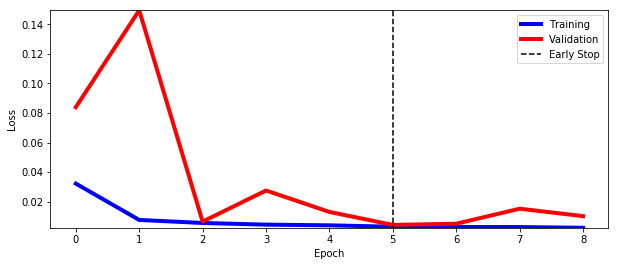

In [24]:
## Plot the learning curves for SPI1  
from dragonn.vis import plot_learning_curve
plot_learning_curve(history_case1_spi1)

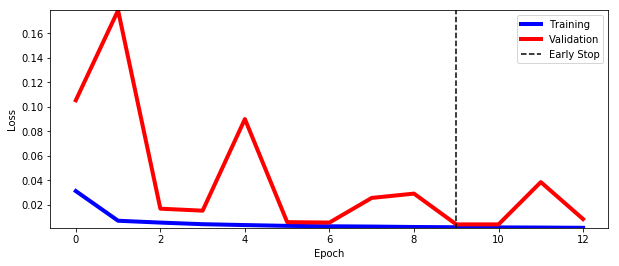

In [25]:
## Plot the learning curve for CTCF 
plot_learning_curve(history_case1_ctcf)

We now measure how well the models performed by calculating performance metrics on the test splits across the whole genome. 

In [26]:
case1_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case1_spi1_test_predictions=case1_spi1_model.predict_generator(case1_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


6047/6047 [==============================] - 333s 55ms/step


In [27]:
case1_ctcf_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case1_ctcf_test_predictions=case1_ctcf_model.predict_generator(case1_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6047/6047 [==============================] - 329s 54ms/step


In [28]:
#format true & predicted test labels for performance assessment 

#if test_set.shape is not a multiple of batch_size, 
#there may be some extra values in test_set that need to get truncated.
spi1_test_truth=np.expand_dims(test_set['SPI1'][0:case1_spi1_test_predictions.shape[0]],1).astype(bool)

In [29]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_truth,case1_spi1_test_predictions))

Loss: nan	Balanced Accuracy: 50.95%	 auROC: 0.641	 auPRC Careful: 0.008	 auPRC Trapezoidal: 0.326
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 30779	 Num Negatives: 6015749


In [30]:
ctcf_test_truth=np.expand_dims(test_set['CTCF'][0:case1_ctcf_test_predictions.shape[0]],1).astype(bool)

In [31]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case1_ctcf_test_predictions))

Loss: nan	Balanced Accuracy: 50.86%	 auROC: 0.677	 auPRC Careful: 0.010	 auPRC Trapezoidal: 0.383
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 37131	 Num Negatives: 6009397


In [69]:
## Save the models 
#save the models 
case1_spi1_model.save("case1_spi1_model.hdf5")
case1_ctcf_model.save("case1_ctcf_model.hdf5")

## Case 2: Whole-genome negatives, single-tasked models <a name='5'>
<a href=#outline>Home</a>

* Since the genomewide imbalance of negative bins to positive bins is very high, we upsample each batch in the training set to contain 30% positive samples. 

In [32]:
#create the generators
from dragonn.generators import * 
case2_spi1_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample_ratio=0.3,batch_size=256)
case2_spi1_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample_ratio=0.02,batch_size=256)
case2_ctcf_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["CTCF"],upsample_ratio=0.3,batch_size=256)
case2_ctcf_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["CTCF"],upsample_ratio=0.02,batch_size=256)


In [33]:
#Train the SPI1 model 
case2_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_spi1=case2_spi1_model.fit_generator(case2_spi1_train_gen,
                                                  validation_data=case2_spi1_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                                             History()])

Epoch 1/150
10000/10000 [==============================] - 477s 48ms/step - loss: 0.1391 - precision: 0.9029 - recall: 0.9155 - specificity: 0.9581 - fpr: 0.0419 - fnr: 0.0844 - fdr: 0.0970 - f1: 0.9035 - val_loss: 0.0850 - val_precision: 0.3393 - val_recall: 0.8746 - val_specificity: 0.9688 - val_fpr: 0.0312 - val_fnr: 0.1229 - val_fdr: 0.6597 - val_f1: 0.4723
Epoch 2/150
10000/10000 [==============================] - 457s 46ms/step - loss: 0.0961 - precision: 0.9301 - recall: 0.9529 - specificity: 0.9693 - fpr: 0.0307 - fnr: 0.0470 - fdr: 0.0698 - f1: 0.9359 - val_loss: 0.1708 - val_precision: 0.1852 - val_recall: 0.9581 - val_specificity: 0.9279 - val_fpr: 0.0721 - val_fnr: 0.0394 - val_fdr: 0.8143 - val_f1: 0.3048
Epoch 3/150
10000/10000 [==============================] - 456s 46ms/step - loss: 0.0826 - precision: 0.9370 - recall: 0.9649 - specificity: 0.9722 - fpr: 0.0278 - fnr: 0.0349 - fdr: 0.0629 - f1: 0.9454 - val_loss: 0.1002 - val_precision: 0.3003 - val_recall: 0.9111 - val

In [34]:
#Train the CTCF model 
case2_ctcf_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case2_ctcf=case2_ctcf_model.fit_generator(case2_ctcf_train_gen,
                                                  validation_data=case2_ctcf_valid_gen,
                                                  epochs=150,
                                                  verbose=1,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                                             History()])

Epoch 1/150
10000/10000 [==============================] - 485s 49ms/step - loss: 0.0852 - precision: 0.9472 - recall: 0.9468 - specificity: 0.9775 - fpr: 0.0225 - fnr: 0.0531 - fdr: 0.0526 - f1: 0.9415 - val_loss: 0.0791 - val_precision: 0.3755 - val_recall: 0.9549 - val_specificity: 0.9706 - val_fpr: 0.0293 - val_fnr: 0.0426 - val_fdr: 0.6235 - val_f1: 0.5229
Epoch 2/150
10000/10000 [==============================] - 473s 47ms/step - loss: 0.0490 - precision: 0.9666 - recall: 0.9755 - specificity: 0.9855 - fpr: 0.0145 - fnr: 0.0244 - fdr: 0.0333 - f1: 0.9658 - val_loss: 0.0723 - val_precision: 0.3756 - val_recall: 0.9527 - val_specificity: 0.9709 - val_fpr: 0.0291 - val_fnr: 0.0448 - val_fdr: 0.6234 - val_f1: 0.5228
Epoch 3/150
10000/10000 [==============================] - 473s 47ms/step - loss: 0.0395 - precision: 0.9713 - recall: 0.9834 - specificity: 0.9875 - fpr: 0.0125 - fnr: 0.0165 - fdr: 0.0286 - f1: 0.9721 - val_loss: 0.0261 - val_precision: 0.7428 - val_recall: 0.8490 - val

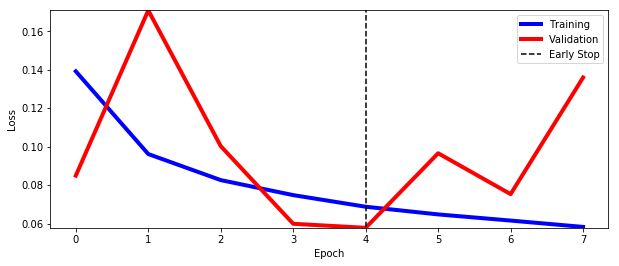

In [35]:
## Plot the learning curves for SPI1  
from dragonn.vis import * 
plot_learning_curve(history_case2_spi1)

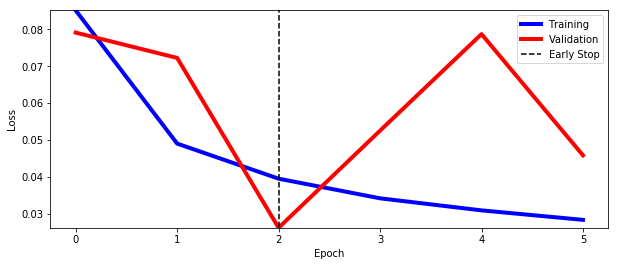

In [36]:
## Plot the learning curves for CTCF  
plot_learning_curve(history_case2_ctcf)

In [37]:
#Get model predictions on the test set 
case2_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case2_spi1_test_predictions=case2_spi1_model.predict_generator(case2_spi1_test_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


6047/6047 [==============================] - 334s 55ms/step


In [38]:
case2_ctcf_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['CTCF'])
case2_ctcf_test_predictions=case2_ctcf_model.predict_generator(case2_ctcf_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6047/6047 [==============================] - 351s 58ms/step


In [39]:
from dragonn.metrics import ClassificationResult
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(spi1_test_truth,case2_spi1_test_predictions))

Loss: 0.0522	Balanced Accuracy: 85.22%	 auROC: 0.976	 auPRC Careful: 0.369	 auPRC Trapezoidal: 0.369
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|5.7%	 Num Positives: 30779	 Num Negatives: 6015749


In [40]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(ctcf_test_truth,case2_ctcf_test_predictions))

Loss: nan	Balanced Accuracy: 83.20%	 auROC: 0.963	 auPRC Careful: 0.592	 auPRC Trapezoidal: 0.592
	Recall at 5%|10%|20% FDR: 0.0%|27.3%|41.6%	 Num Positives: 37131	 Num Negatives: 6009397


In [71]:
#save the models 
case2_spi1_model.save("case2_spi1_model.hdf5")
case2_ctcf_model.save("case2_ctcf_model.hdf5")

## Case 3: Whole-genome negatives, multi-tasked models <a name='6'>
<a href=#outline>Home</a>

In [41]:
#create the generators for multi-tasked models. Guarantee 30% positives in each batch
# Upsample validation generator to match the test set fraction of positives. 
case3_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,batch_size=256)
case3_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",upsample_ratio=0.02,batch_size=256)

In [42]:
#Train the multi-tasked model  
case3_model=initialize_model(ntasks=4)

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case3=case3_model.fit_generator(case3_train_gen,
                                        validation_data=case3_valid_gen,
                                        steps_per_epoch=10000,
                                        validation_steps=5000,
                                        epochs=150,
                                        verbose=1,
                                        use_multiprocessing=True,
                                        workers=40,
                                        max_queue_size=100,
                                        callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 456s 46ms/step - loss: 0.1154 - precision: 0.8134 - recall: 0.6692 - specificity: 0.9849 - fpr: 0.0151 - fnr: 0.3306 - fdr: 0.1864 - f1: 0.7233 - val_loss: 0.0650 - val_precision: 0.1815 - val_recall: 0.7605 - val_specificity: 0.9830 - val_fpr: 0.0169 - val_fnr: 0.2373 - val_fdr: 0.8180 - val_f1: 0.2848
Epoch 2/150
10000/10000 [==============================] - 443s 44ms/step - loss: 0.0860 - precision: 0.8535 - recall: 0.7679 - specificity: 0.9871 - fpr: 0.0129 - fnr: 0.2320 - fdr: 0.1463 - f1: 0.8022 - val_loss: 0.0272 - val_precision: 0.3388 - val_recall: 0.7118 - val_specificity: 0.9928 - val_fpr: 0.0072 - val_fnr: 0.2860 - val_fdr: 0.6599 - val_f1: 0.4385
Epoch 3/150
10000/10000 [==============================] - 443s 44ms/step - loss: 0.0792 - precision: 0.8596 - recall: 0.7894 - specificity: 0.9874 - fpr: 0.0126 - fnr: 0.2105 - fdr: 0.1403 - f1: 0.8169 - val_loss: 0.0366 - val_precision: 0.2360 - val_recall: 0.7705 - val

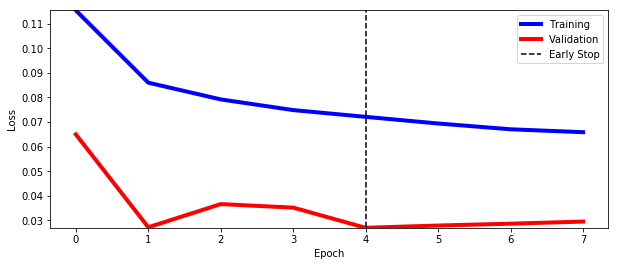

In [43]:
## Plot the learning curves for the multi-tasked model   
from dragonn.vis import * 
plot_learning_curve(history_case3)

In [44]:
case3_test_gen=DataGenerator("TF.test.hdf5",
                             "hg19.genome.fa.gz",
                             upsample=False,
                             add_revcomp=False,
                             batch_size=1000)
case3_test_predictions=case3_model.predict_generator(case3_test_gen,
                                                     max_queue_size=5000, 
                                                     workers=40, 
                                                     use_multiprocessing=True, 
                                                     verbose=1)


6047/6047 [==============================] - 330s 55ms/step


In [45]:
test_truth=test_set[0:case3_test_predictions.shape[0]].astype(bool)

In [46]:
test_truth.columns

Index(['CTCF', 'SPI1', 'SIX5', 'ZNF143'], dtype='object')

In [47]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['SPI1'],1),
                           np.expand_dims(case3_test_predictions[:,0],1)))

Loss: inf	Balanced Accuracy: 51.76%	 auROC: 0.711	 auPRC Careful: 0.012	 auPRC Trapezoidal: 0.012
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 30779	 Num Negatives: 6015749


In [48]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['CTCF'],1),
                           np.expand_dims(case3_test_predictions[:,1],1)))

Loss: 0.0824	Balanced Accuracy: 51.09%	 auROC: 0.739	 auPRC Careful: 0.013	 auPRC Trapezoidal: 0.013
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 37131	 Num Negatives: 6009397


In [49]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['ZNF143'],1),
                           np.expand_dims(case3_test_predictions[:,2],1)))

Loss: 0.0603	Balanced Accuracy: 53.06%	 auROC: 0.836	 auPRC Careful: 0.145	 auPRC Trapezoidal: 0.145
	Recall at 5%|10%|20% FDR: 1.3%|2.1%|3.3%	 Num Positives: 57175	 Num Negatives: 5989353


In [50]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(np.expand_dims(test_truth['SIX5'],1),
                           np.expand_dims(case3_test_predictions[:,3],1)))

Loss: 0.0482	Balanced Accuracy: 67.17%	 auROC: 0.773	 auPRC Careful: 0.137	 auPRC Trapezoidal: 0.137
	Recall at 5%|10%|20% FDR: 1.2%|2.4%|4.8%	 Num Positives: 18042	 Num Negatives: 6028486


In [70]:
## save the model 
#save the models 
case3_model.save("case3_model.hdf5")

## Case 4: What happens if we don't upsample positive examples in our batches? <a name='7'>
<a href=#outline>Home</a>

In [51]:
#create the generators
case4_spi1_train_gen=DataGenerator("TF.train.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False,batch_size=256)
case4_spi1_valid_gen=DataGenerator("TF.valid.hdf5","hg19.genome.fa.gz",tasks=["SPI1"],upsample=False,batch_size=256)

In [52]:
#Train the SPI1 model 
case4_spi1_model=initialize_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_case4_spi1=case4_spi1_model.fit_generator(case4_spi1_train_gen,
                                                  validation_data=case4_spi1_valid_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 493s 49ms/step - loss: 0.0238 - precision: 2.3588e-05 - recall: 6.8676e-05 - specificity: 0.9990 - fpr: 9.5072e-04 - fnr: 0.0734 - fdr: 0.0097 - f1: 3.0956e-05 - val_loss: 0.0637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_fpr: 0.0000e+00 - val_fnr: 0.1163 - val_fdr: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/150
10000/10000 [==============================] - 482s 48ms/step - loss: 0.0151 - precision: 9.9298e-04 - recall: 2.1225e-04 - specificity: 1.0000 - fpr: 7.8122e-06 - fnr: 0.0780 - fdr: 0.0013 - f1: 3.3540e-04 - val_loss: 0.0195 - val_precision: 0.0107 - val_recall: 0.0028 - val_specificity: 0.9999 - val_fpr: 7.8199e-05 - val_fnr: 0.1057 - val_fdr: 0.0105 - val_f1: 0.0040
Epoch 3/150
10000/10000 [==============================] - 481s 48ms/step - loss: 0.0126 - precision: 0.0066 - recall: 0.0017 - specificity: 0.9999 - fpr: 4.0741e-05 - fnr: 0.0753 - fdr: 0.0072 - f1: 0.0024 - val_los

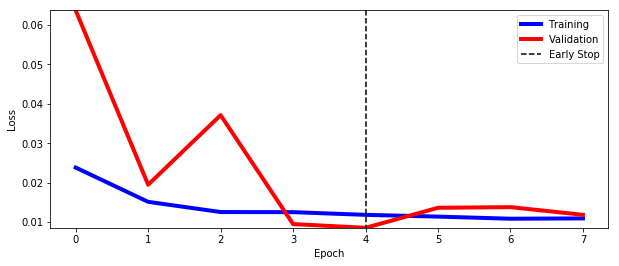

In [53]:
## Plot the learning curves for SPI1  
plot_learning_curve(history_case4_spi1)

In [54]:
#We  use a custom batch_predict function to generate predictions on the test set, one batch at a time 
case4_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])
case4_spi1_test_predictions=case4_spi1_model.predict_generator(case4_spi1_test_gen,max_queue_size=5000, workers=40, use_multiprocessing=True, verbose=1)


6047/6047 [==============================] - 333s 55ms/step


In [58]:

## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(spi1_test_truth,case4_spi1_test_predictions))


Loss: 0.0204	Balanced Accuracy: 52.56%	 auROC: 0.942	 auPRC Careful: 0.227	 auPRC Trapezoidal: 0.227
	Recall at 5%|10%|20% FDR: 0.2%|0.5%|1.4%	 Num Positives: 30779	 Num Negatives: 6015749


In [72]:
#save the model
case4_spi1_model.save("case4_spi1_model.hdf5")

In [73]:
##Save the test predictions from the four models 
#save the test set predictions 
import h5py 
test_set_predictions=h5py.File("test_set_predictions.hdf5",'w')
test_set_predictions.create_dataset("case1_spi1_test_predictions",data=case1_spi1_test_predictions)
test_set_predictions.create_dataset("case1_ctcf_test_predictions",data=case1_ctcf_test_predictions)
test_set_predictions.create_dataset("case2_spi1_test_predictions",data=case2_spi1_test_predictions)
test_set_predictions.create_dataset("case2_ctcf_test_predictions",data=case2_ctcf_test_predictions)
test_set_predictions.create_dataset("case3_test_predictions",data=case3_test_predictions)
test_set_predictions.create_dataset("case4_spi1_test_predictions",data=case4_spi1_test_predictions)
test_set_predictions.close() 

## Calibrate model predictions with Platt Scaling  <a name='8'>
<a href=#outline>Home</a>

The next step is to calibrate the model predictions such that a threshold of 0.5 can be used to determine whether a prediction should round up to 1 (True) or down to 0 (False). The [Platt scaling algorithm](https://en.wikipedia.org/wiki/Platt_scaling) can be used to transform the outputs of our classification model into a probability distribution over different classes. 

In [56]:
#calibration will be performed on the logits of the model, so we use a trick to obtain these logits --
# we create a new model that wraps around "spi1_classification_model" and provides the logits (layer -2)
from keras.models import Model 
target_layer_idx=-2
classification_preact_model=Model(inputs=case2_spi1_model.input,
                   outputs=case2_spi1_model.layers[target_layer_idx].output)


In [60]:
#We now reset the test set generator and obtain the prediction logits from the preact model. 
# It is important to reset the generator to preserve the order of the input samples. 
case2_spi1_test_gen=DataGenerator("TF.test.hdf5",
                                   "hg19.genome.fa.gz",
                                     upsample=False,
                                     add_revcomp=False,
                                     batch_size=1000,
                                     tasks=['SPI1'])

In [61]:
spi1_test_classification_logits=classification_preact_model.predict_generator(case2_spi1_test_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)

6047/6047 [==============================] - 305s 50ms/step


In [62]:
#We obtain the Platt Scaling calibration function 
from dragonn.calibration import * 
spi1_classification_calibration_func=get_calibration_function_classification(spi1_test_classification_logits,
                                                     case2_spi1_test_gen.data)


Platt scaling coef: 0.4291136823938912 ; intercept: -2.761053170960728
Platt scaling coef: 0.11417807084207635 ; intercept: -3.5155432382210785


In [63]:
#We use the Platt Scaling calibration function to obtain calibrated predictions on the test set 
spi1_test_classification_calibrated_predictions=get_calibrated_predictions(spi1_test_classification_logits,
                                                                           spi1_classification_calibration_func)

(6046528, 1)
(6046528, 1)


In [65]:
#spi1_test_classification_calibrated_predictions=np.expand_dims(spi1_test_classification_calibrated_predictions[~nan_indices],axis=1)
print(ClassificationResult(spi1_test_truth,
                           spi1_test_classification_calibrated_predictions))

Loss: 0.0162	Balanced Accuracy: 55.41%	 auROC: 0.976	 auPRC Careful: 0.369	 auPRC Trapezoidal: 0.369
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|5.2%	 Num Positives: 30779	 Num Negatives: 6015749


Note that most of the metrics have not changed, with the exception of Balanced Accuracy. This value decreased to 57.43%, 
reflecting the calibrated threshold for separating positive and negative predictions. 

## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='9'>
<a href=#outline>Home</a>

The highest test set auPRC was observed in Case 2 -- the single-tasked, genome-wide, SPI1 model with upsampling of positives. Let's interpet some high-confidence true positives. 


In [66]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
true_pos_spi1=test_truth[spi1_test_truth*case2_spi1_test_predictions >0.9]
true_pos_spi1.head

<bound method NDFrame.head of                           CTCF  SPI1   SIX5  ZNF143
CHR   START    END                                 
chr2  191450   192450    False  True  False   False
      191500   192500    False  True  False   False
      191550   192550    False  True  False   False
      191600   192600    False  True  False   False
      191650   192650    False  True  False   False
      215700   216700    False  True  False   False
      215800   216800    False  True  False   False
      215850   216850    False  True  False   False
      257050   258050    False  True  False   False
      257100   258100    False  True  False   False
      257150   258150    False  True  False   False
      257200   258200    False  True  False   False
      257250   258250    False  True  False   False
      268950   269950    False  True  False   False
      269000   270000    False  True  False   False
      269050   270050    False  True  False   False
      269100   270100    False  Tr

In [67]:
true_pos_spi1.shape

(16751, 4)

In [68]:
from dragonn.utils import one_hot_from_bed
deep_lift_input_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
deep_lift_input_spi1.shape

(16751, 1, 1000, 4)

In [93]:
from dragonn.interpret import * 

#we obtain the deepLIFT function to use with this model 
deeplift_score_func_classification_spi1=get_deeplift_scoring_function("case2_spi1_model.hdf5")

In [94]:
help(multi_method_interpret)

Help on function multi_method_interpret in module dragonn.interpret:

multi_method_interpret(model, X, task_idx, deeplift_score_func, motif_names=None, batch_size=200, target_layer_idx=-2, num_refs_per_seq=10, reference='shuffled_ref', one_hot_func=None, pfm=None, GC_fraction=0.4, generate_plots=True)
    Arguments:
        model -- keras model object 
        X -- numpy array with shape (1, 1, n_bases_in_sample,4) or list of FASTA sequences 
        task_idx -- numerical index (starting with 0)  of task to interpet. For a single-tasked model, you should set this to 0 
        deeplift_score_fun -- scoring function to use with DeepLIFT algorithm. 
        motif_names -- a list of motif name strings to scan for in the input sequence; if this is unknown, keep the default value of None  
        batch_size -- number of samples to interpret at once 
        target_layer_idx -- should be -2 for classification; -1 for regression 
        reference -- one of 'shuffled_ref','gc_ref','zero_ref'

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


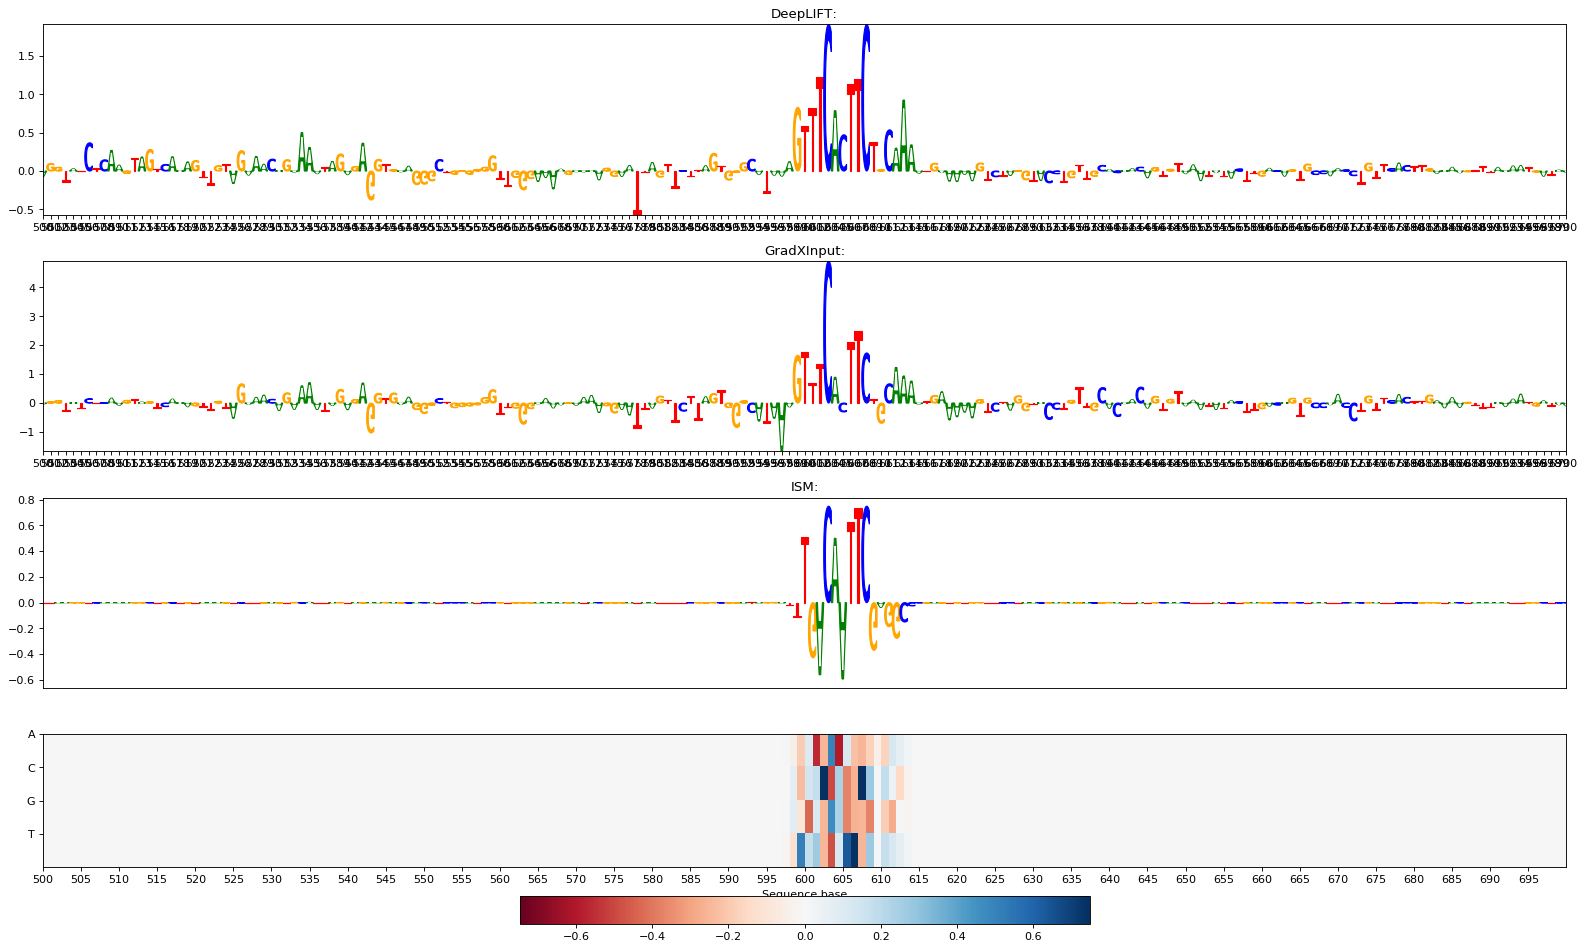

In [95]:
example0=np.expand_dims(deep_lift_input_spi1[0],axis=0)
pos_interpretations=multi_method_interpret(case2_spi1_model,
                                           example0,
                                           0,
                                           deeplift_score_func_classification_spi1,
                                           generate_plots=False)
from dragonn.vis import * 
plot_all_interpretations([pos_interpretations],example0,xlim=(500,700))


getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


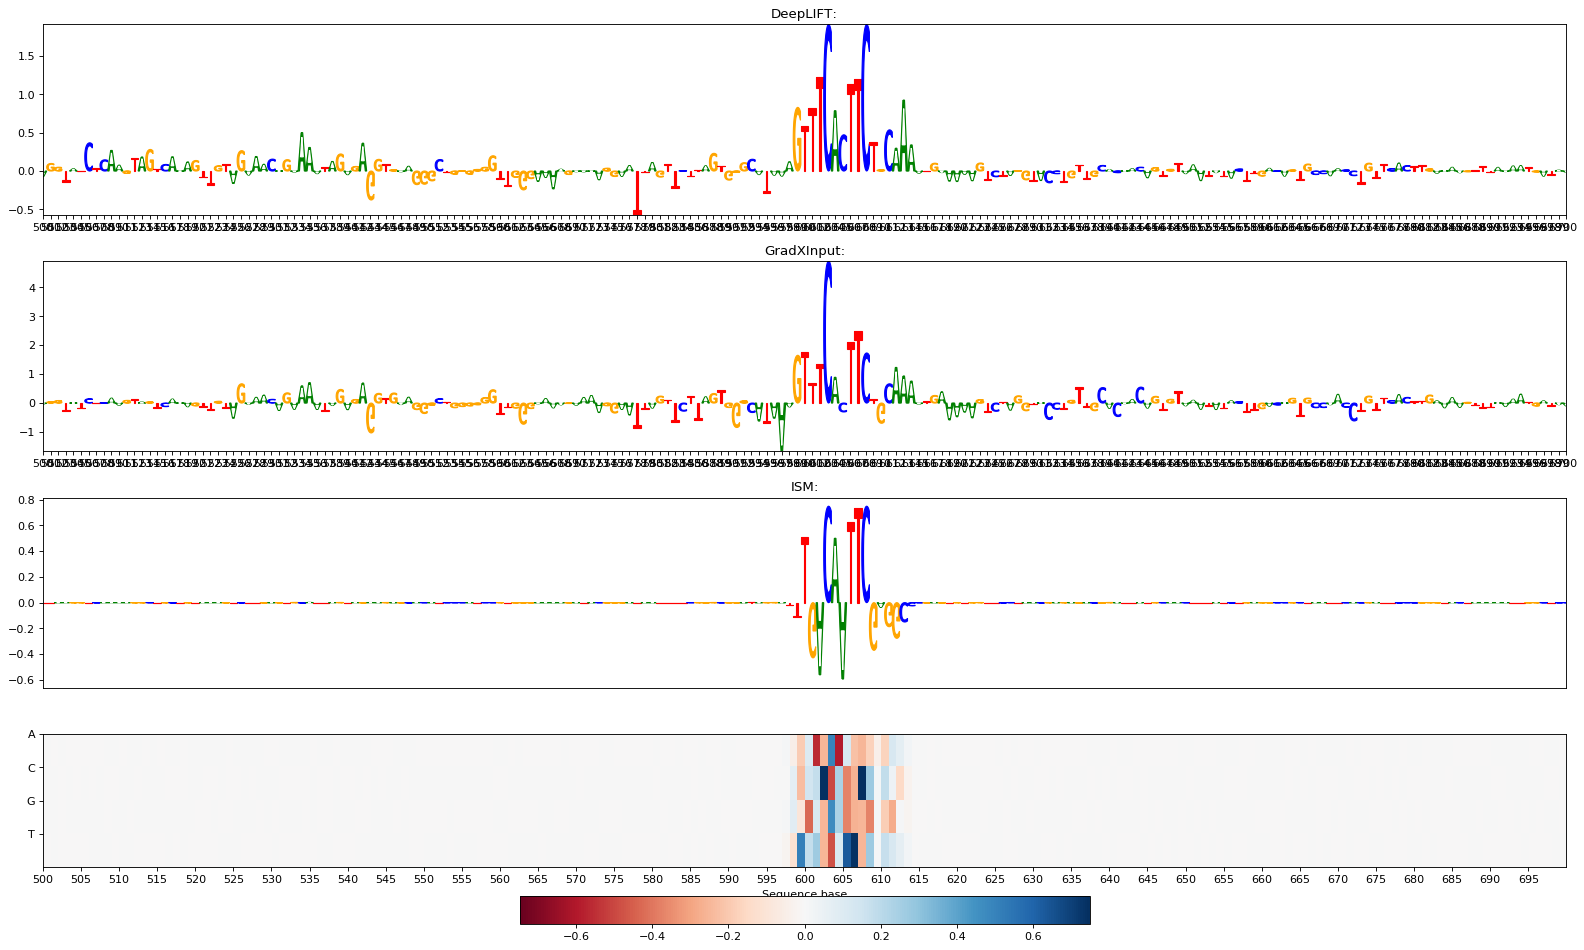

In [97]:
example1=np.expand_dims(deep_lift_input_spi1[0],axis=0)
pos_interpretations=multi_method_interpret(case2_spi1_model,
                                           example1,
                                           0,
                                           deeplift_score_func_classification_spi1,
                                           generate_plots=False)
from dragonn.vis import * 
plot_all_interpretations([pos_interpretations],example1,xlim=(500,700))


getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


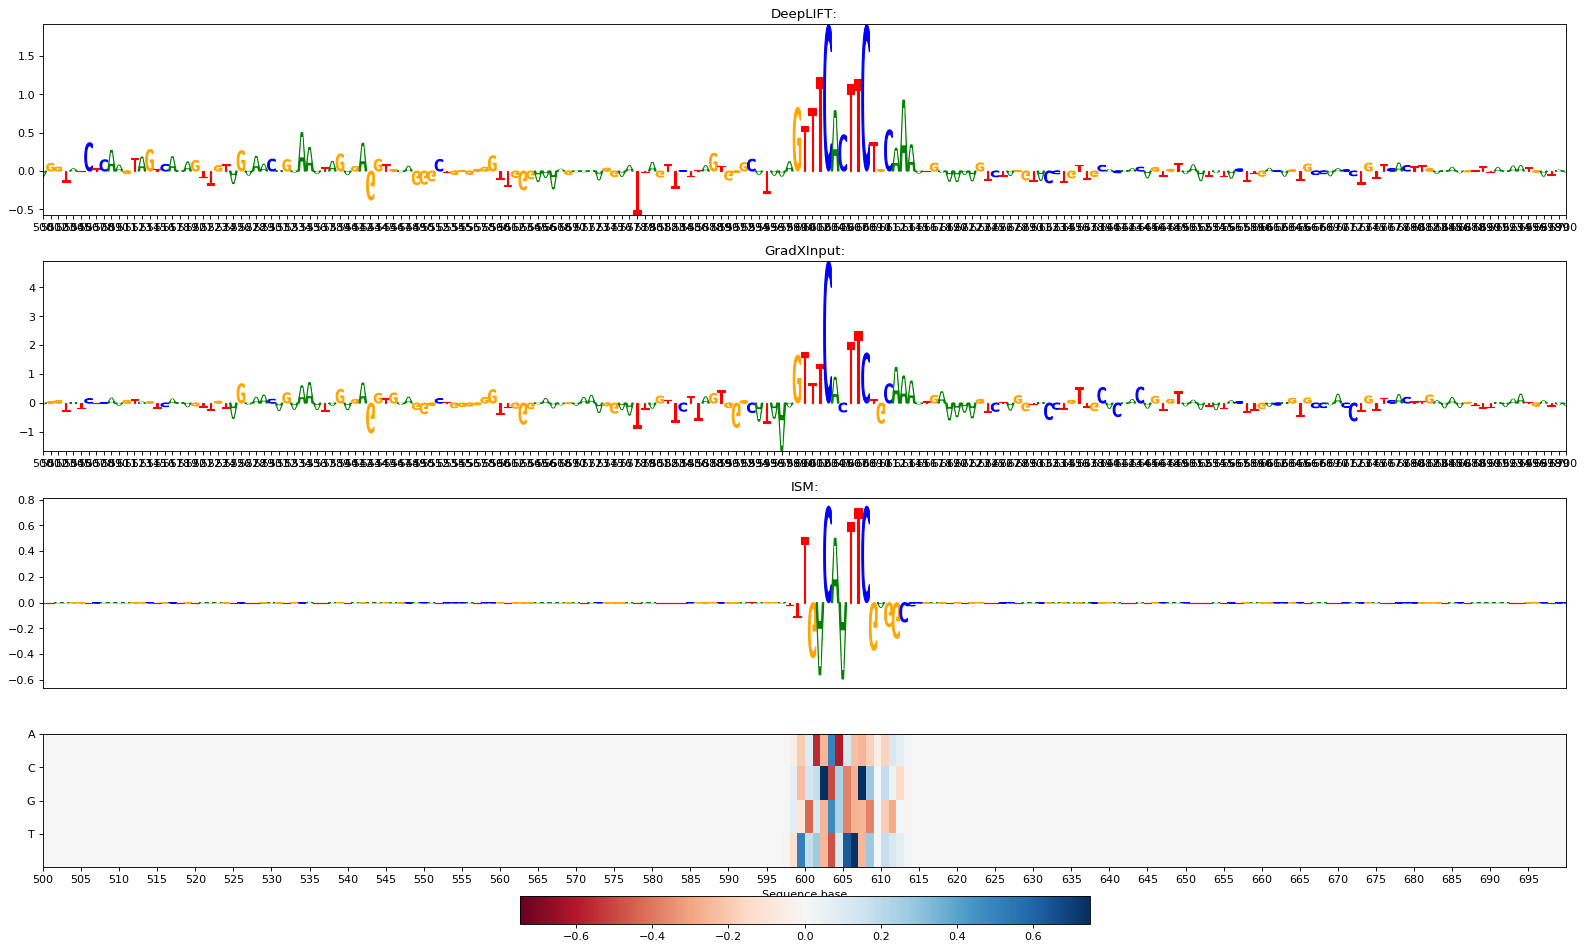

In [98]:
example2=np.expand_dims(deep_lift_input_spi1[0],axis=0)
pos_interpretations=multi_method_interpret(case2_spi1_model,
                                           example2,
                                           0,
                                           deeplift_score_func_classification_spi1,
                                           generate_plots=False)
from dragonn.vis import * 
plot_all_interpretations([pos_interpretations],example2,xlim=(500,700))


If we query the sequence "TCACTTCCCCTT" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match for SPIB (p-value = 8.93e-7): 
<img src="tutorial_images/SPI1.Tut4.png" alt="SPI1TomTom" width="400"/>


Let's interpret the high-confidence true positives from the CTCF model

In [103]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence predictions)
true_pos_ctcf=test_truth[ctcf_test_truth*case2_ctcf_test_predictions >0.9]
deep_lift_input_ctcf=one_hot_from_bed([i for i in true_pos_ctcf.index],"hg19.genome.fa.gz")

In [104]:
deeplift_score_func_classification_ctcf=get_deeplift_scoring_function("case2_ctcf_model.hdf5")

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


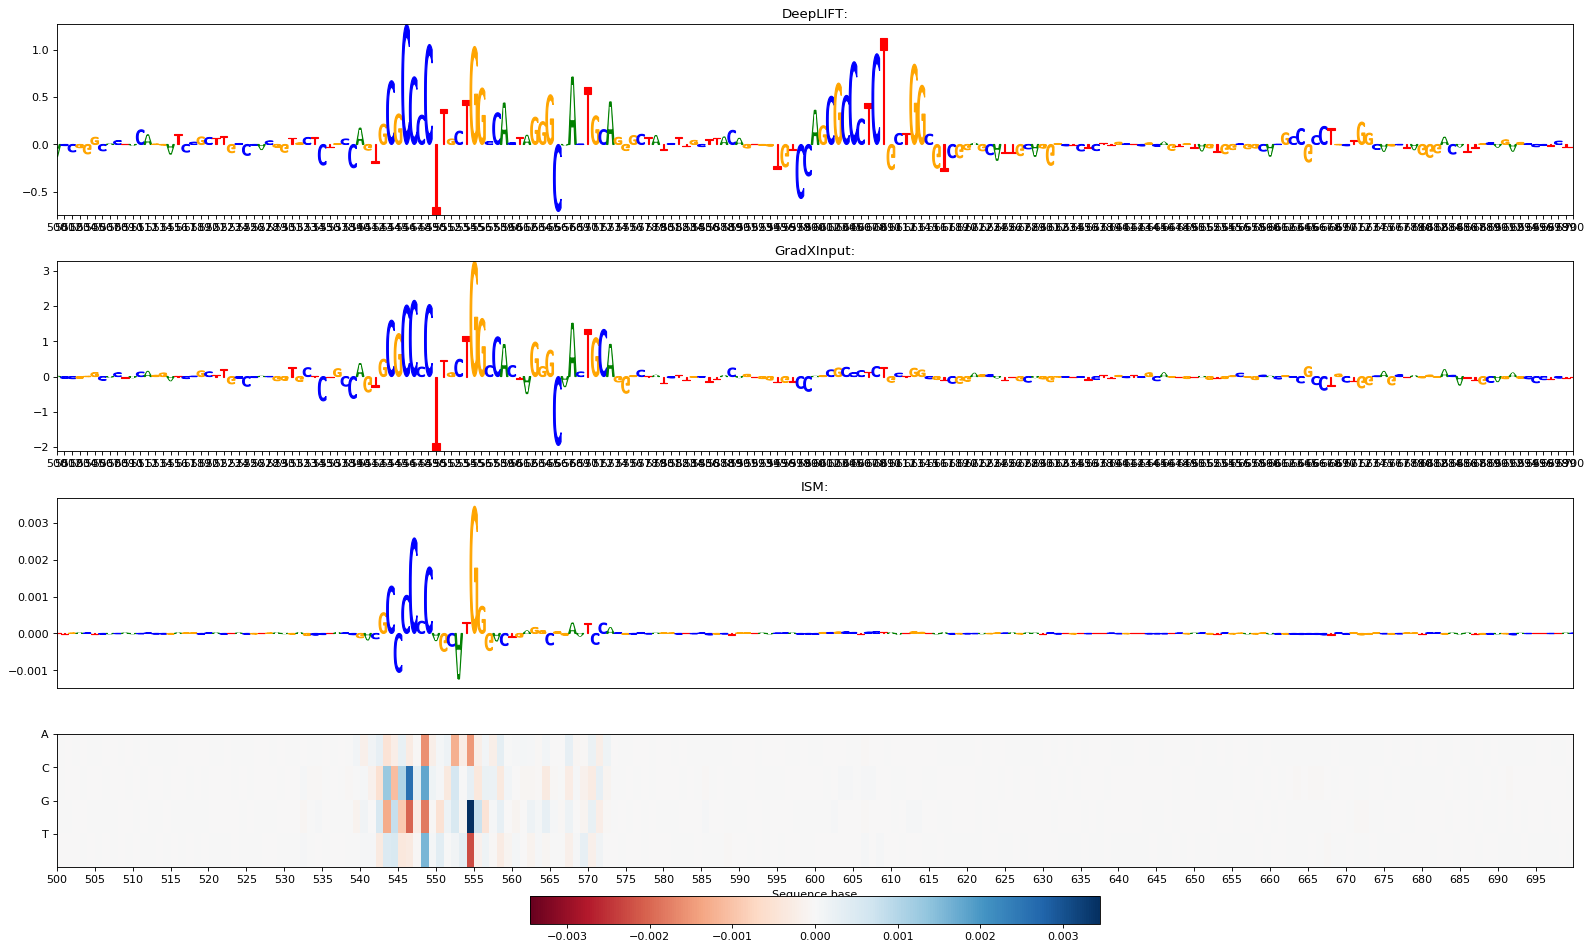

In [105]:
example3=np.expand_dims(deep_lift_input_ctcf[0],axis=0)
pos_interpretations=multi_method_interpret(case2_ctcf_model,
                                           example3,
                                           0,
                                           deeplift_score_func_classification_ctcf,
                                           generate_plots=False)
plot_all_interpretations([pos_interpretations],example3,xlim=(500,700))

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


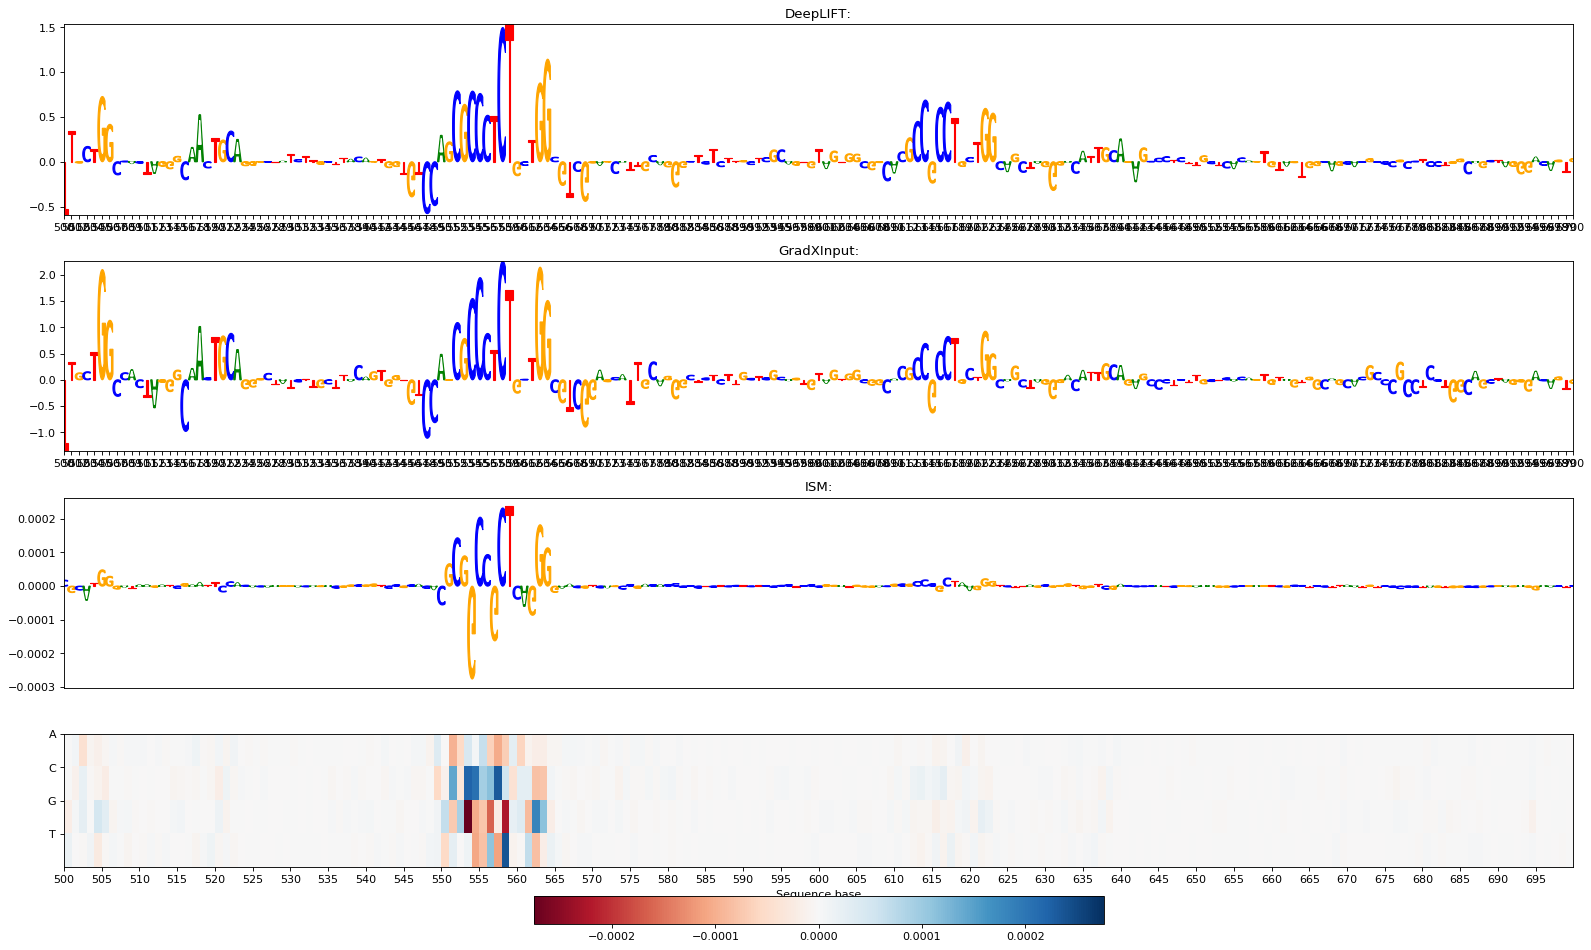

In [106]:
example4=np.expand_dims(deep_lift_input_ctcf[1],axis=0)
pos_interpretations=multi_method_interpret(case2_ctcf_model,
                                           example4,
                                           0,
                                           deeplift_score_func_classification_ctcf,
                                           generate_plots=False)
plot_all_interpretations([pos_interpretations],example4,xlim=(500,700))

Querying the sequence "GCGCCCTCTGCTGG" in TomTom confirms a strong match (p=1.43e-6) to the canonical CTCF motif:
<img src="tutorial_images/CTCF.Tut4.png" alt="CTCFTomTom" width="400"/>


## Conclusions <a name='10'>
<a href=#outline>Home</a>

From our analysis of *in vivo* transcription factor ChiP-seq datasets, we draw the following conclusions: 

* Training the models genome-wide by splitting the genome into short (200 bp), overlapping (stride=50) bins leads to improved generalization performance on the test set as compared to "easier" negative sets. I.E we observed superior test set performance for both the SPI1 and CTCF tasks when training on the whole genome as compared to using shuffled reference negatives. 


* Due to high class imbalance in *in vivo* data, it is necessary to upsample positive examples in each batch to facilitate model training. We found that upsampling positives to constitute 30% of each batch worked well --i.e. interpretation with DeepLIFT indicates the model learned the correct motif in CTCF and SPI1 ChIP-seq datasets. What happens if you alter the *upsample_ratio* parameter in the generator function? Does the model learn equally well with *upsample_ratio=0.1*? Does it learn better or worse with *upsample_ratio=0.5*? 


* Multi-tasking can lead to improved performance for tasks that are similar (i.e. CTCF/ZNF143/SIX5 are similar motifs). However, multi-tasking does not improve performance on tasks that are different (i.e. the SPI1 motif does not resemble the other three motifs, so multi-tasking does not improve performance for the SPI1 task). 
